# XENON1T S2-only: results for custom energy spectra

_May 2020, XENON collaboration_

This notebook shows how to derive limits on custom dark matter signal models with XENON1T's S2-only data. If you use this notebook, or the provided data, please cite our paper:
  * Aprile, E. _et al._ (XENON collaboration), [Phys. Rev. Lett. 123, 251801](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.251801) (2019).

The notebook does not replace the full analysis performed by XENON1T, and omits some elements that would be difficult to distribute. However, as shown below, it is designed to provide a highly accurate approximation.

For questions and comments, please contact contact@xenon1t.org.

## §1. Load the response functions and binning

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate, integrate

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load response matrix and energies
response_df = pd.read_csv('s2_response_nr.csv')
response_matrix = response_df.values[:,3:]
energy_kev = response_df['energy_kev'].values

# We simulated mono-energetic signals. To construct models,
# we have to weight them by a d(energy), i.e. a width.
energy_bin_starts_kev = response_df['energy_bin_start_kev'].values
energy_bin_end_kev = response_df['energy_bin_end_kev'].values
energy_bin_width_kev = energy_bin_end_kev - energy_bin_starts_kev

# Load S2 binning
binning_df = pd.read_csv('s2_binning_info.csv')
s2_bin_centers = binning_df['log_center_pe'].values
s2_bin_widths = (binning_df['end_pe'] - binning_df['start_pe']).values
s2_bin_edges = np.concatenate([binning_df['start_pe'].values, [binning_df['end_pe'].iloc[-1]]])

## §2. Compute the energy spectrum

If you are a phenomenologist, insert your amazing dark matter candidate model here. 

For this example, we will use a 4 GeV/c^2 spin-independent elastic WIMP spectrum, computed using the `wimprates` package (available on pypi / pip install). As a reference cross-section, we'll use 1 zb or $10^{-45} \mathrm{cm^2}$.

/home/aalbers/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  


(0.4, 10)

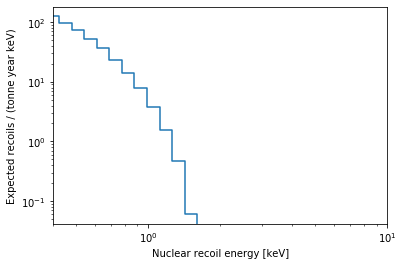

In [3]:
import wimprates as wr
reference_cross_section = 1e-45  # cm^2
rate_pertonneyearkev = wr.rate_wimp_std(
    es=energy_kev, 
    mw=4, 
    sigma_nucleon=reference_cross_section)

plt.plot(energy_kev, rate_pertonneyearkev, linestyle='steps-mid')
plt.xlabel("Nuclear recoil energy [keV]")
plt.ylabel("Expected recoils / (tonne year keV)")
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.4, 10)

## §3. Convert to expected measured S2 rate

First, we muliply by the energy bin weight and the total exposure:

In [4]:
rate_pertonneyear = rate_pertonneyearkev * energy_bin_width_kev
rate_before_cutoff = rate_pertonneyear * 0.97678   # tonne year

See the README.md file for more details on how the total exposure in the last line is derived. Of course this is not the **effective** exposure; we have many event selection cuts. These, together with the LXe and detector response, are accounted for in the response model, which we will apply in a moment.

The response model does **not** include any recoil energy cutoffs (so you can vary the cutoff if you want). For NRs, we applied a 0.7 keV energy cutoff in our paper. Let's apply that here.

In [5]:
recoil_energy_cutoff_kev = 0.7
rate_after_cutoff = rate_before_cutoff.copy()

# Which bin contains the cutoff?
cutoff_bin_index = (energy_bin_starts_kev < recoil_energy_cutoff_kev).sum() - 1

# Zero the spectrum in earlier bins
rate_after_cutoff[:cutoff_bin_index] = 0

# Suppress the spectrum proportionally in the bin with the cutoff
suppress_by = (
    (recoil_energy_cutoff_kev - energy_bin_starts_kev[cutoff_bin_index]) 
    / energy_bin_width_kev[cutoff_bin_index])
assert 0 <= suppress_by <= 1
rate_after_cutoff[cutoff_bin_index] *= 1 - suppress_by

/home/aalbers/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  """Entry point for launching an IPython kernel.
/home/aalbers/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  


(0.4, 10)

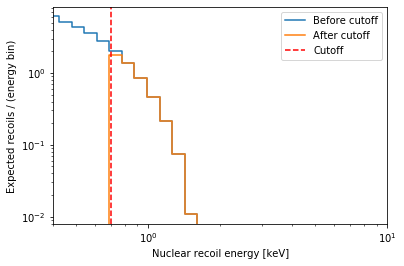

In [6]:
plt.plot(energy_kev, rate_before_cutoff, linestyle='steps-mid', label='Before cutoff')
plt.plot(energy_kev, rate_after_cutoff, linestyle='steps-mid', label='After cutoff')
plt.axvline(recoil_energy_cutoff_kev, linestyle='--', c='r', label='Cutoff')
plt.legend(loc='best')
plt.xlabel("Nuclear recoil energy [keV]")
plt.ylabel("Expected recoils / (energy bin)")
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.4, 10)

Finally, take the dot product with the response matrix:

/home/aalbers/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  # Remove the CWD from sys.path while we load stuff.


(0, 0.0017664119392907208)

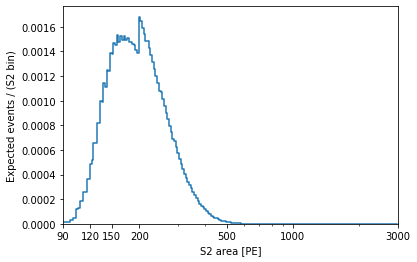

In [7]:
rate_final = np.dot(response_matrix.T, rate_after_cutoff)

def s2_xaxis():
    plt.xscale('log')
    plt.xticks([90, 120, 150, 200, 500, 1000, 3000])
    plt.xlim(90, 3000)
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlabel("S2 area [PE]")
    
plt.plot(s2_bin_centers, rate_final, linestyle='steps-mid')
plt.ylabel("Expected events / (S2 bin)")
s2_xaxis()
plt.ylim(0, None)

**Do not compare this to figure 4 in the paper.** Figure 4 showed event rates scaled by the effective exposure, in very large bins. The plot right here shows the unscaled event count in very narrow bins.

Moreover, it is NOT possible to recreate figure 4 with the information provided here. The 'effective exposure' used to make figure 4 was the exposure averaged over z at constant S2. We chose to scale by this because it does not reference an underlying model or true energy. However, such a quantity never appears in the calculation of expected event counts for any physical model. Figure 1 instead gives the effective exposure for specific true energies, averaged over S2 and z; this information is included in the response matrices provided here. 

## §4. ROI choice and limit setting

You now need to choose an S2 region of interest (ROI) for comparison with data. You have several options:

**1.** If you do not want to think about this issue, or if your model has most of its response at low S2s, stick to our [165.3, 271.7] PE ROI.
  
**2.** If your model has a significant response at higher S2s, you will get better results with a different ROI.
  * **2A:** We list many ROIs in the limit datafiles, for different WIMP masses, models, and several mono-energetic peaks (for dark photons and ALPs). You could compare your model's response to one of these reference models, see which matches best, and use its ROI.
  * **2B:** Alternatively, you can choose a completely new ROI, e.g. by trying to approximate our procedure. This is more work, and you will need some extra info.
  
Whatever you do, do NOT just choose the ROI that gives you the best results! We chose our ROIs before even looking at the search data.
  
Here, we assume you chose one of our ROIs, i.e. option **[1]** or **[2A]**. We'll briefly discuss **[2B]** in the next section.

In [8]:
s2_roi = (165.3, 271.7)

You now want to count the expected number of events in the ROI. Since we have quite a few S2 bins, a naive calculation is reasonable:

In [9]:
mask = (s2_roi[0] <= s2_bin_centers) & (s2_bin_centers <= s2_roi[1])
expected_events = rate_final[mask].sum()
expected_events

0.037718471821271776

But feel free to interpolate/integrate:

In [10]:
f = interpolate.interp1d(s2_bin_centers, rate_final / s2_bin_widths)
expected_events, integration_error = integrate.quad(f, *s2_roi)

print(expected_events, integration_error/expected_events)

0.03822934845106809 1.2621799818834301e-05


/home/aalbers/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


Since you picked one of the ROIs from our paper, you can look up the limit in terms of number of signal events.

For this ROI, we derived limits of **24.6 - 24.8 signal events** for different models.
  * The tiny spread is due to slightly different impacts of our uncertainties for different models that have different distributions within the small S2 ROI.
  * If you would like more details on how this limit is derived from the observed data, please see the paper. You do not need these details for the computation here.

Computing the limit is now easy:

In [11]:
24.7 * reference_cross_section / expected_events

6.461004699469291e-43

For comparison, the full calculation with XENON1T's framework gives $6.4367 \times 10^{-43} \mathrm{cm}^2$, as you can get from the supplemental CSVs. 

Thus, for this signal model, we reproduce our limit to within 1%. We give no guarantees this is true for all signal models, particularly signal models with energy spectra that drop very steeply compared to the provided energy binning.

## §5. Optional: choosing a custom ROI

It is by far the simplest to choose one of the ROIs we also used, as discussed above.

We chose ROIs before examining the search data. Specifically, we chose S2 ROIs that gave the lowest limit for each model on a disjoint training set, which was not re-used for setting the actual dark matter limits. The ROIs also had to obey several constraints (to contain sufficient signal, and not include < 150 PE events) as detailed in the paper.

This data release has information to approximately (but not exactly) repeat this construction. You will need to do your own counting experiment limit setting in the presence of a background, and scan over different ROIs. A full example is beyond the scope of this notebook.

Here, we just show how to load the two other pieces of data provided to help those who want to go down this road.

#### Observed events

(0, 10.5)

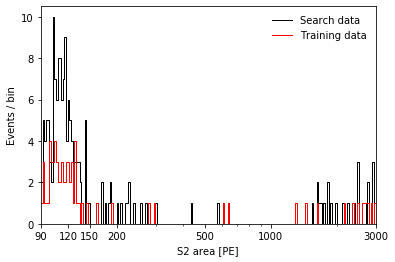

In [12]:
from multihist import Hist1d
s2s = pd.read_csv('events_after_cuts.csv')['s2_area_pe'].values
s2s_train = pd.read_csv('events_after_cuts_training.csv')['s2_area_pe'].values

Hist1d(s2s, bins=s2_bin_edges).plot(c='k', label='Search data')
Hist1d(s2s_train, bins=s2_bin_edges).plot(c='r', label='Training data')
plt.legend(loc='upper right', frameon=False)
s2_xaxis()
plt.ylabel("Events / bin")
plt.ylim(0, None)

In our ROI for low-mass models, there are (as mentioned above) 16 events in the search data:

In [13]:
sum((s2_roi[0] <= s2s) & (s2s <= s2_roi[1]))

16

As you can see in red in the figure above, we also provided the training data events. Recall that the total exposure of the training dataset is 3/7th that of the search data (i.e. 0.41862 tonne year).

#### Background models

Only the ER and CEvNS background models can be conveniently distributed, since the cathode background model is estimated by a data-driven method that depends on the ROI and several control samples (see the paper's supplemental material).

The provided background models have all detector and analysis effects and efficiencies included. Thus, you do not need to apply any response model to them. 

(0, 0.32751625684000896)

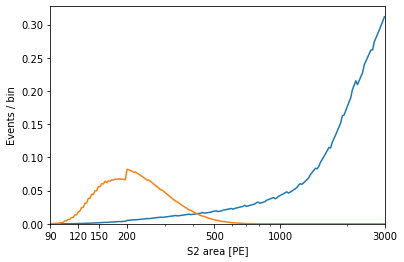

In [14]:
df_bg = pd.read_csv('er_and_cevns_background.csv')
plt.plot(s2_bin_centers, df_bg['er_background_events'])
plt.plot(s2_bin_centers, df_bg['cevns_background_events'])
s2_xaxis()
plt.ylabel("Events / bin")
plt.ylim(0, None)

The (10-20%) uncertainties on the models are not straightforward to distribute; they are highly correlated across S2 bins due to their origin in e.g. cut acceptance and signal model uncertainties.

Please see the note at the end of §3 on why this can NOT be compared to figure 4 in the paper.